In [1]:
# importing libaries

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import scipy.io

In [2]:
class LEMCell(nn.Module):
    def __init__(self, ninp, nhid, dt):
        super(LEMCell, self).__init__()
        self.ninp = ninp
        self.nhid = nhid
        self.dt = dt
        self.inp2hid = nn.Linear(ninp, 4 * nhid)
        self.hid2hid = nn.Linear(nhid, 3 * nhid)
        self.transform_z = nn.Linear(nhid, nhid)
        self.reset_parameters()

    def reset_parameters(self):
        std = 1.0 / np.sqrt(self.nhid)
        for w in self.parameters():
            w.data.uniform_(-std, std)

    def forward(self, x, y, z):
        transformed_inp = self.inp2hid(x)
        transformed_hid = self.hid2hid(y)
        i_dt1, i_dt2, i_z, i_y = transformed_inp.chunk(4, 1)
        h_dt1, h_dt2, h_y = transformed_hid.chunk(3, 1)

        ms_dt_bar = self.dt * torch.sigmoid(i_dt1 + h_dt1)
        ms_dt = self.dt * torch.sigmoid(i_dt2 + h_dt2)

        z = (1. - ms_dt) * z + ms_dt * torch.tanh(i_y + h_y)
        y = (1. - ms_dt_bar) * y + ms_dt_bar * torch.tanh(self.transform_z(z) + i_z)

        return y, z

# Define the LEM model
class LEM(nn.Module):
    def __init__(self, ninp, nhid, nout, dt=1.):
        super(LEM, self).__init__()
        self.nhid = nhid
        self.cell = LEMCell(ninp, nhid, dt)
        self.classifier = nn.Linear(nhid, nout)
        self.init_weights()

    def init_weights(self):
        for name, param in self.named_parameters():
            if 'classifier' in name and 'weight' in name:
                nn.init.kaiming_normal_(param.data)

    def forward(self, input):
        y = input.data.new(input.size(1), self.nhid).zero_()
        z = input.data.new(input.size(1), self.nhid).zero_()
        for x in input:
            y, z = self.cell(x, y, z)
        out = self.classifier(y)
        return out

In [3]:
# Toy problem data
input_size = 256  # number of columns in a dataset
hidden_size = 32  # number of neurons
output_size = 256  
sequence_length = 160  # number of sequences/ number of rows
batch_size = 1
num_epochs = 20000

In [4]:
# importing data

In [5]:
# Load the .mat file
v_data = scipy.io.loadmat('v.mat')
h_data = scipy.io.loadmat('h.mat')
x_data = scipy.io.loadmat('x.mat')
h_data

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Thu Jul 20 15:02:48 2023',
 '__version__': '1.0',
 '__globals__': [],
 'h': array([[0.03949907, 0.03945555, 0.03968762, ..., 0.04081577, 0.04034067,
         0.03995187],
        [0.03949522, 0.03972834, 0.04007071, ..., 0.0406224 , 0.0405568 ,
         0.04021852],
        [0.03980837, 0.03966293, 0.04008707, ..., 0.04077249, 0.04050591,
         0.04019281],
        ...,
        [0.04915863, 0.04935256, 0.04961976, ..., 0.04917885, 0.04899574,
         0.04881741],
        [0.04904458, 0.04916197, 0.04943338, ..., 0.04902097, 0.04897786,
         0.04875013],
        [0.04913692, 0.04932824, 0.04941899, ..., 0.04888785, 0.0488357 ,
         0.04855312]])}

In [6]:
x = x_data['X']
u = h_data['h']

In [7]:
print(x.shape)
print(u.shape)
u

(201, 256)
(201, 256)


array([[0.03949907, 0.03945555, 0.03968762, ..., 0.04081577, 0.04034067,
        0.03995187],
       [0.03949522, 0.03972834, 0.04007071, ..., 0.0406224 , 0.0405568 ,
        0.04021852],
       [0.03980837, 0.03966293, 0.04008707, ..., 0.04077249, 0.04050591,
        0.04019281],
       ...,
       [0.04915863, 0.04935256, 0.04961976, ..., 0.04917885, 0.04899574,
        0.04881741],
       [0.04904458, 0.04916197, 0.04943338, ..., 0.04902097, 0.04897786,
        0.04875013],
       [0.04913692, 0.04932824, 0.04941899, ..., 0.04888785, 0.0488357 ,
        0.04855312]])

In [8]:
# Set random seed for reproducibility
torch.manual_seed(42)

In [9]:
input_data = u[0:160,:]
target_data = u[1:161, :]

test_data = u[160:200, :]
test_target = u[161:201, :]

print("test data shape", test_data.shape)
print("test target shape", test_target.shape)

print("input data shape",input_data.shape)
print("Target data shape",target_data.shape)

test data shape (40, 256)
test target shape (40, 256)
input data shape (160, 256)
Target data shape (160, 256)


In [10]:
# Convert data to tensors
input_tensor = torch.tensor(input_data).view(batch_size, sequence_length, input_size).float()
target_tensor = torch.tensor(target_data).view(batch_size, sequence_length, output_size).float()

print("input tensor shape",input_tensor.shape)
print("Target tensor shape",target_tensor.shape)

input tensor shape torch.Size([1, 160, 256])
Target tensor shape torch.Size([1, 160, 256])


In [11]:
# Convert test data to tensors
test_tensor = torch.tensor(test_data).view(batch_size, 40, input_size).float()
test_target_tensor = torch.tensor(test_target).view(batch_size, 40, output_size).float()


In [12]:
# Create LEM instance
lem = LEM(input_size, hidden_size, output_size, dt=0.1)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lem.parameters(), lr=0.001)



# Training loop
for epoch in range(num_epochs):
    # Forward pass
    output = lem(input_tensor)
    loss = criterion(output, target_tensor)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print progress
    if (epoch + 1) % 10 == 0:
        print(f'Epoch: {epoch + 1}/{num_epochs}, Loss: {loss.item():.6f}')




Epoch: 10/20000, Loss: 0.688335
Epoch: 20/20000, Loss: 0.644207
Epoch: 30/20000, Loss: 0.603241
Epoch: 40/20000, Loss: 0.560971


/data/localhome/tkapoor/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([1, 160, 256])) that is different to the input size (torch.Size([160, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 50/20000, Loss: 0.518000
Epoch: 60/20000, Loss: 0.479887
Epoch: 70/20000, Loss: 0.447305
Epoch: 80/20000, Loss: 0.418399
Epoch: 90/20000, Loss: 0.392489
Epoch: 100/20000, Loss: 0.369106
Epoch: 110/20000, Loss: 0.347846
Epoch: 120/20000, Loss: 0.328397
Epoch: 130/20000, Loss: 0.310514
Epoch: 140/20000, Loss: 0.294003
Epoch: 150/20000, Loss: 0.278706
Epoch: 160/20000, Loss: 0.264493
Epoch: 170/20000, Loss: 0.251253
Epoch: 180/20000, Loss: 0.238891
Epoch: 190/20000, Loss: 0.227325
Epoch: 200/20000, Loss: 0.216485
Epoch: 210/20000, Loss: 0.206308
Epoch: 220/20000, Loss: 0.196740
Epoch: 230/20000, Loss: 0.187732
Epoch: 240/20000, Loss: 0.179241
Epoch: 250/20000, Loss: 0.171230
Epoch: 260/20000, Loss: 0.163663
Epoch: 270/20000, Loss: 0.156509
Epoch: 280/20000, Loss: 0.149742
Epoch: 290/20000, Loss: 0.143335
Epoch: 300/20000, Loss: 0.137267
Epoch: 310/20000, Loss: 0.131517
Epoch: 320/20000, Loss: 0.126065
Epoch: 330/20000, Loss: 0.120895
Epoch: 340/20000, Loss: 0.115991
Epoch: 350/2000

Epoch: 2490/20000, Loss: 0.018162
Epoch: 2500/20000, Loss: 0.018057
Epoch: 2510/20000, Loss: 0.017954
Epoch: 2520/20000, Loss: 0.017851
Epoch: 2530/20000, Loss: 0.017750
Epoch: 2540/20000, Loss: 0.017649
Epoch: 2550/20000, Loss: 0.017548
Epoch: 2560/20000, Loss: 0.017449
Epoch: 2570/20000, Loss: 0.017350
Epoch: 2580/20000, Loss: 0.017252
Epoch: 2590/20000, Loss: 0.017155
Epoch: 2600/20000, Loss: 0.017058
Epoch: 2610/20000, Loss: 0.016962
Epoch: 2620/20000, Loss: 0.016867
Epoch: 2630/20000, Loss: 0.016773
Epoch: 2640/20000, Loss: 0.016679
Epoch: 2650/20000, Loss: 0.016586
Epoch: 2660/20000, Loss: 0.016493
Epoch: 2670/20000, Loss: 0.016401
Epoch: 2680/20000, Loss: 0.016310
Epoch: 2690/20000, Loss: 0.016220
Epoch: 2700/20000, Loss: 0.016130
Epoch: 2710/20000, Loss: 0.016040
Epoch: 2720/20000, Loss: 0.015952
Epoch: 2730/20000, Loss: 0.015863
Epoch: 2740/20000, Loss: 0.015776
Epoch: 2750/20000, Loss: 0.015689
Epoch: 2760/20000, Loss: 0.015602
Epoch: 2770/20000, Loss: 0.015517
Epoch: 2780/20

Epoch: 4900/20000, Loss: 0.000812
Epoch: 4910/20000, Loss: 0.000794
Epoch: 4920/20000, Loss: 0.000777
Epoch: 4930/20000, Loss: 0.000760
Epoch: 4940/20000, Loss: 0.000744
Epoch: 4950/20000, Loss: 0.000732
Epoch: 4960/20000, Loss: 0.000714
Epoch: 4970/20000, Loss: 0.000700
Epoch: 4980/20000, Loss: 0.000685
Epoch: 4990/20000, Loss: 0.000672
Epoch: 5000/20000, Loss: 0.000658
Epoch: 5010/20000, Loss: 0.000646
Epoch: 5020/20000, Loss: 0.000633
Epoch: 5030/20000, Loss: 0.000621
Epoch: 5040/20000, Loss: 0.000610
Epoch: 5050/20000, Loss: 0.000598
Epoch: 5060/20000, Loss: 0.000587
Epoch: 5070/20000, Loss: 0.000577
Epoch: 5080/20000, Loss: 0.000566
Epoch: 5090/20000, Loss: 0.000556
Epoch: 5100/20000, Loss: 0.000546
Epoch: 5110/20000, Loss: 0.000537
Epoch: 5120/20000, Loss: 0.000527
Epoch: 5130/20000, Loss: 0.000518
Epoch: 5140/20000, Loss: 0.000509
Epoch: 5150/20000, Loss: 0.000501
Epoch: 5160/20000, Loss: 0.000492
Epoch: 5170/20000, Loss: 0.000484
Epoch: 5180/20000, Loss: 0.000477
Epoch: 5190/20

Epoch: 7330/20000, Loss: 0.000048
Epoch: 7340/20000, Loss: 0.000048
Epoch: 7350/20000, Loss: 0.000048
Epoch: 7360/20000, Loss: 0.000047
Epoch: 7370/20000, Loss: 0.000047
Epoch: 7380/20000, Loss: 0.000047
Epoch: 7390/20000, Loss: 0.000046
Epoch: 7400/20000, Loss: 0.000046
Epoch: 7410/20000, Loss: 0.000046
Epoch: 7420/20000, Loss: 0.000045
Epoch: 7430/20000, Loss: 0.000045
Epoch: 7440/20000, Loss: 0.000044
Epoch: 7450/20000, Loss: 0.000045
Epoch: 7460/20000, Loss: 0.000044
Epoch: 7470/20000, Loss: 0.000043
Epoch: 7480/20000, Loss: 0.000043
Epoch: 7490/20000, Loss: 0.000043
Epoch: 7500/20000, Loss: 0.000043
Epoch: 7510/20000, Loss: 0.000042
Epoch: 7520/20000, Loss: 0.000042
Epoch: 7530/20000, Loss: 0.000041
Epoch: 7540/20000, Loss: 0.000041
Epoch: 7550/20000, Loss: 0.000041
Epoch: 7560/20000, Loss: 0.000040
Epoch: 7570/20000, Loss: 0.000040
Epoch: 7580/20000, Loss: 0.000040
Epoch: 7590/20000, Loss: 0.000040
Epoch: 7600/20000, Loss: 0.000039
Epoch: 7610/20000, Loss: 0.000039
Epoch: 7620/20

Epoch: 9760/20000, Loss: 0.000011
Epoch: 9770/20000, Loss: 0.000011
Epoch: 9780/20000, Loss: 0.000010
Epoch: 9790/20000, Loss: 0.000010
Epoch: 9800/20000, Loss: 0.000010
Epoch: 9810/20000, Loss: 0.000010
Epoch: 9820/20000, Loss: 0.000010
Epoch: 9830/20000, Loss: 0.000010
Epoch: 9840/20000, Loss: 0.000009
Epoch: 9850/20000, Loss: 0.000009
Epoch: 9860/20000, Loss: 0.000009
Epoch: 9870/20000, Loss: 0.000009
Epoch: 9880/20000, Loss: 0.000009
Epoch: 9890/20000, Loss: 0.000009
Epoch: 9900/20000, Loss: 0.000009
Epoch: 9910/20000, Loss: 0.000009
Epoch: 9920/20000, Loss: 0.000009
Epoch: 9930/20000, Loss: 0.000009
Epoch: 9940/20000, Loss: 0.000009
Epoch: 9950/20000, Loss: 0.000009
Epoch: 9960/20000, Loss: 0.000009
Epoch: 9970/20000, Loss: 0.000009
Epoch: 9980/20000, Loss: 0.000009
Epoch: 9990/20000, Loss: 0.000009
Epoch: 10000/20000, Loss: 0.000009
Epoch: 10010/20000, Loss: 0.000009
Epoch: 10020/20000, Loss: 0.000013
Epoch: 10030/20000, Loss: 0.000011
Epoch: 10040/20000, Loss: 0.000009
Epoch: 10

Epoch: 12120/20000, Loss: 0.000004
Epoch: 12130/20000, Loss: 0.000004
Epoch: 12140/20000, Loss: 0.000004
Epoch: 12150/20000, Loss: 0.000004
Epoch: 12160/20000, Loss: 0.000005
Epoch: 12170/20000, Loss: 0.000009
Epoch: 12180/20000, Loss: 0.000006
Epoch: 12190/20000, Loss: 0.000004
Epoch: 12200/20000, Loss: 0.000004
Epoch: 12210/20000, Loss: 0.000004
Epoch: 12220/20000, Loss: 0.000004
Epoch: 12230/20000, Loss: 0.000004
Epoch: 12240/20000, Loss: 0.000004
Epoch: 12250/20000, Loss: 0.000004
Epoch: 12260/20000, Loss: 0.000004
Epoch: 12270/20000, Loss: 0.000004
Epoch: 12280/20000, Loss: 0.000004
Epoch: 12290/20000, Loss: 0.000004
Epoch: 12300/20000, Loss: 0.000004
Epoch: 12310/20000, Loss: 0.000004
Epoch: 12320/20000, Loss: 0.000004
Epoch: 12330/20000, Loss: 0.000004
Epoch: 12340/20000, Loss: 0.000004
Epoch: 12350/20000, Loss: 0.000004
Epoch: 12360/20000, Loss: 0.000004
Epoch: 12370/20000, Loss: 0.000004
Epoch: 12380/20000, Loss: 0.000004
Epoch: 12390/20000, Loss: 0.000011
Epoch: 12400/20000, 

Epoch: 14530/20000, Loss: 0.000003
Epoch: 14540/20000, Loss: 0.000003
Epoch: 14550/20000, Loss: 0.000003
Epoch: 14560/20000, Loss: 0.000003
Epoch: 14570/20000, Loss: 0.000003
Epoch: 14580/20000, Loss: 0.000003
Epoch: 14590/20000, Loss: 0.000003
Epoch: 14600/20000, Loss: 0.000003
Epoch: 14610/20000, Loss: 0.000003
Epoch: 14620/20000, Loss: 0.000003
Epoch: 14630/20000, Loss: 0.000003
Epoch: 14640/20000, Loss: 0.000003
Epoch: 14650/20000, Loss: 0.000003
Epoch: 14660/20000, Loss: 0.000003
Epoch: 14670/20000, Loss: 0.000003
Epoch: 14680/20000, Loss: 0.000003
Epoch: 14690/20000, Loss: 0.000003
Epoch: 14700/20000, Loss: 0.000005
Epoch: 14710/20000, Loss: 0.000006
Epoch: 14720/20000, Loss: 0.000003
Epoch: 14730/20000, Loss: 0.000003
Epoch: 14740/20000, Loss: 0.000003
Epoch: 14750/20000, Loss: 0.000003
Epoch: 14760/20000, Loss: 0.000003
Epoch: 14770/20000, Loss: 0.000003
Epoch: 14780/20000, Loss: 0.000003
Epoch: 14790/20000, Loss: 0.000003
Epoch: 14800/20000, Loss: 0.000003
Epoch: 14810/20000, 

Epoch: 16900/20000, Loss: 0.000002
Epoch: 16910/20000, Loss: 0.000002
Epoch: 16920/20000, Loss: 0.000002
Epoch: 16930/20000, Loss: 0.000002
Epoch: 16940/20000, Loss: 0.000002
Epoch: 16950/20000, Loss: 0.000002
Epoch: 16960/20000, Loss: 0.000003
Epoch: 16970/20000, Loss: 0.000006
Epoch: 16980/20000, Loss: 0.000003
Epoch: 16990/20000, Loss: 0.000002
Epoch: 17000/20000, Loss: 0.000002
Epoch: 17010/20000, Loss: 0.000002
Epoch: 17020/20000, Loss: 0.000002
Epoch: 17030/20000, Loss: 0.000002
Epoch: 17040/20000, Loss: 0.000002
Epoch: 17050/20000, Loss: 0.000002
Epoch: 17060/20000, Loss: 0.000002
Epoch: 17070/20000, Loss: 0.000002
Epoch: 17080/20000, Loss: 0.000002
Epoch: 17090/20000, Loss: 0.000006
Epoch: 17100/20000, Loss: 0.000003
Epoch: 17110/20000, Loss: 0.000003
Epoch: 17120/20000, Loss: 0.000002
Epoch: 17130/20000, Loss: 0.000002
Epoch: 17140/20000, Loss: 0.000002
Epoch: 17150/20000, Loss: 0.000002
Epoch: 17160/20000, Loss: 0.000002
Epoch: 17170/20000, Loss: 0.000002
Epoch: 17180/20000, 

Epoch: 19250/20000, Loss: 0.000002
Epoch: 19260/20000, Loss: 0.000002
Epoch: 19270/20000, Loss: 0.000002
Epoch: 19280/20000, Loss: 0.000007
Epoch: 19290/20000, Loss: 0.000004
Epoch: 19300/20000, Loss: 0.000002
Epoch: 19310/20000, Loss: 0.000002
Epoch: 19320/20000, Loss: 0.000002
Epoch: 19330/20000, Loss: 0.000002
Epoch: 19340/20000, Loss: 0.000002
Epoch: 19350/20000, Loss: 0.000002
Epoch: 19360/20000, Loss: 0.000002
Epoch: 19370/20000, Loss: 0.000002
Epoch: 19380/20000, Loss: 0.000002
Epoch: 19390/20000, Loss: 0.000002
Epoch: 19400/20000, Loss: 0.000002
Epoch: 19410/20000, Loss: 0.000002
Epoch: 19420/20000, Loss: 0.000002
Epoch: 19430/20000, Loss: 0.000002
Epoch: 19440/20000, Loss: 0.000002
Epoch: 19450/20000, Loss: 0.000002
Epoch: 19460/20000, Loss: 0.000010
Epoch: 19470/20000, Loss: 0.000002
Epoch: 19480/20000, Loss: 0.000002
Epoch: 19490/20000, Loss: 0.000002
Epoch: 19500/20000, Loss: 0.000002
Epoch: 19510/20000, Loss: 0.000002
Epoch: 19520/20000, Loss: 0.000002
Epoch: 19530/20000, 

In [32]:
t[:, -40]

array([1.26449104])

(1, 256)
(1, 201)
(256, 201)


/data/localhome/tkapoor/.local/lib/python3.8/site-packages/numpy/ma/core.py:2820: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.8/dist-packages/matplotlib/contour.py:1180: ComplexWarning: Casting complex values to real discards the imaginary part
  self.levels = np.asarray(levels_arg).astype(np.float64)


<Figure size 720x288 with 0 Axes>

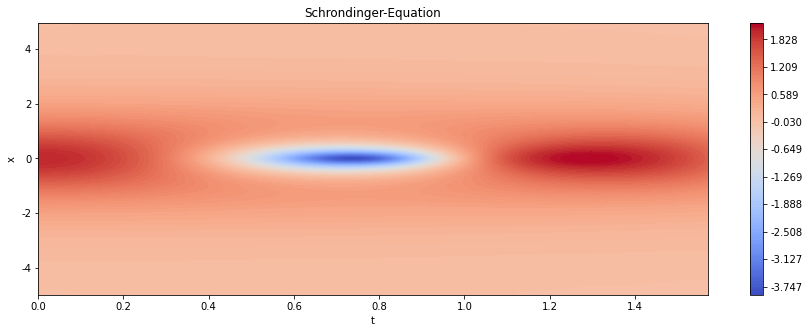

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from sklearn.model_selection import train_test_split

# Load the .mat file
mat_data = scipy.io.loadmat('NLS.mat')

# Following is the code to plot the data u vs x and t. u is 256*100
# matrix. Use first 75 columns for training and 25 for testing :)

# Access the variables stored in the .mat file
# The variable names in the .mat file become keys in the loaded dictionary
x = mat_data['x']
t = mat_data['tt']
u = mat_data['uu']

# Use the loaded variables as needed
print(x.shape)
print(t.shape)
print(u.shape)

X, T = np.meshgrid(x, t)
# Define custom color levels
c_levels = np.linspace(np.min(u), np.max(u), 100)

# Plot the contour
plt.figure()
plt.figure(figsize=(15, 5))
plt.contourf(T, X, u.T, levels=c_levels, cmap='coolwarm')
plt.xlabel('t')
plt.ylabel('x')
plt.title('Schrondinger-Equation')
plt.colorbar()  # Add a colorbar for the contour levels
plt.show()

### 80 percent PINN solution 20 lem prediction in contour plot

In [17]:
prediction.shape

torch.Size([40, 256])

In [18]:
input_tensor.shape

torch.Size([1, 160, 256])

In [19]:
conc_u = torch.squeeze(input_tensor)

In [20]:
concatenated_tensor = torch.cat((conc_u, prediction), dim=0)

concatenated_tensor.shape

torch.Size([200, 256])

In [22]:
t

array([[0.        , 0.00785398, 0.01570796, 0.02356194, 0.03141593,
        0.03926991, 0.04712389, 0.05497787, 0.06283185, 0.07068583,
        0.07853982, 0.0863938 , 0.09424778, 0.10210176, 0.10995574,
        0.11780972, 0.12566371, 0.13351769, 0.14137167, 0.14922565,
        0.15707963, 0.16493361, 0.1727876 , 0.18064158, 0.18849556,
        0.19634954, 0.20420352, 0.2120575 , 0.21991149, 0.22776547,
        0.23561945, 0.24347343, 0.25132741, 0.25918139, 0.26703538,
        0.27488936, 0.28274334, 0.29059732, 0.2984513 , 0.30630528,
        0.31415927, 0.32201325, 0.32986723, 0.33772121, 0.34557519,
        0.35342917, 0.36128316, 0.36913714, 0.37699112, 0.3848451 ,
        0.39269908, 0.40055306, 0.40840704, 0.41626103, 0.42411501,
        0.43196899, 0.43982297, 0.44767695, 0.45553093, 0.46338492,
        0.4712389 , 0.47909288, 0.48694686, 0.49480084, 0.50265482,
        0.51050881, 0.51836279, 0.52621677, 0.53407075, 0.54192473,
        0.54977871, 0.5576327 , 0.56548668, 0.57

In [23]:
t1 = np.linspace(0, 1.5707 , 200)

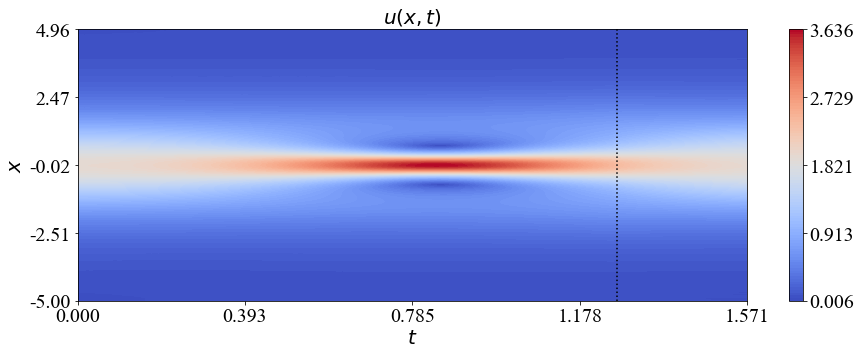

In [33]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator

# Assuming you have defined concatenated_tensor as a PyTorch tensor
# concatenated_tensor = torch.cat((tensor1, tensor2), dim=0)

# Convert concatenated_tensor to a NumPy array
concatenated_array = concatenated_tensor.numpy()

# Define custom color levels
X, T = np.meshgrid(x, t1)

# Define custom color levels using the minimum and maximum from the NumPy array
c_levels = np.linspace(np.min(concatenated_array), np.max(concatenated_array), 100)

# Plot the contour
plt.figure(figsize=(15, 5))
CS1 = plt.contourf(T, X, concatenated_array, levels=c_levels, cmap='coolwarm')

# Create a custom font with Times New Roman
plt.rcParams['figure.figsize'] = [10, 4]

from matplotlib.font_manager import FontProperties
plt.rcParams['axes.unicode_minus'] = False
font_path = 'times-new-roman.ttf'
custom_font = FontProperties(fname=font_path)

cbar1 = plt.colorbar(CS1)
# Set the number of ticks for the color bar with uniformly distributed numbers
num_ticks = 5
c_ticks = np.linspace(np.min(concatenated_array), np.max(concatenated_array), num_ticks)
cbar1.set_ticks(c_ticks)

for t in cbar1.ax.get_yticklabels():
    t.set_fontproperties(custom_font)
    t.set_fontsize(20)

plt.xlabel('$t$', fontsize=20, fontproperties=custom_font)
plt.ylabel('$x$', fontsize=20, fontproperties=custom_font)
plt.title('$u(x, t)$', fontsize=20, fontproperties=custom_font)
plt.xticks(fontsize=20, fontproperties=custom_font)
plt.yticks(fontsize=20, fontproperties=custom_font)

# Add a dotted line at t = 0.8
plt.axvline(x=1.26449, color='black', linestyle='dotted')

# Set the number of ticks for x-axis and y-axis to 5
num_ticks = 5
x_ticks = np.linspace(np.min(T), np.max(T), num_ticks)
y_ticks = np.linspace(np.min(X), np.max(X), num_ticks)

plt.gca().xaxis.set_major_locator(FixedLocator(x_ticks))
plt.gca().yaxis.set_major_locator(FixedLocator(y_ticks))
cbar1.locator = FixedLocator(c_ticks)

plt.savefig('Schr_80_20.pdf', dpi=300)
plt.savefig('schr_80_20.png', dpi=300)
# Show the plot
plt.show()
